# K-Means Clustering: A simple introduction
Clustering describes a set of problems where the goal is to automatically identify groups from a set of observations (data). These groups are called clusters and can be described by the following general definition: "Observation from the same cluster are more similar than observations from different clusters." 

A more formal definition of clustering is given by the K-Means problem. Given $n$ datapoints $x_i$, that have to be devided into $k$ clusters, each described by a cluster center $\mu_j$ which is the mean of all datapoints that belong to the cluster $j$. Find the cluster centers that minimize the following loss function: 

$$ J = \sum_{j=1}^{k} \sum_{x_i \in S_{j}} {\| x_i - \mu_j \|^2}$$
where $S_j$ is the set of all datapoints that are mapped to the cluster $j$ with cluster center $\mu_j$.

Finding an optimal solution for the k-means problem is np-hard, therefore there are several algorithms that find _good_ approximate (locally optimal) solutions. The most well-known algorithm is the _Loyds algorithm_ or _the k-means algorithm_.

After the initialization (e.g., randomly choose cluster center among the data points), this algorithm consists of only two steps: 
- __Assigment:__
Assign every point to the cluster center (centroid) that is closest.
- __Update:__
Calculate new centroids as the average position of all points assigned to a cluster.



### Generate example data
We will now try our own implementation of the k-means algorithm.
At first we generate some artificial training data. The data will consist of two features (e.g., x-y coordinates). 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, n_features=2, random_state=random_state, cluster_std=1.2)

print(X[0:10,:])

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=50)

[[ -5.3198574    0.75249082]
 [ -5.98487648   0.48460018]
 [-11.22445972  -7.9716744 ]
 [ -4.56730382  -0.97897324]
 [ -3.30511661   0.02946152]
 [  1.53694847   0.81562926]
 [ -9.91246995  -5.15107857]
 [-12.02286529  -3.90285899]
 [ -7.48269121  -5.94732589]
 [  2.82413      3.85744585]]


### Step 1: Initialize
The first step of the k-means algorithm is to choose an initial set of clustering centers. Here we implement this in a very simple fashion, we simply choose a random datapoint and make sure that we don't choose the same datapoint twice.

In [2]:
def init_centroids(k, X):
    """Choose random datapoints as centers for k-means
    
    k = number of clusters
    X = data [numpy array]
    
    return: 
    centroids [tuple]: A tuple of arrays with the coordinates of the 
                       new cluster centers"""
    
    
    centroids = []
    for i in range(k):
        rand = np.random.randint(0,len(X)-1)
        randVal = tuple(X[rand,:])
        while randVal in centroids:
            # the while loop makes sure that you don't choose the same points twice
            rand = np.random.randint(0,len(X)-1)
            randVal = tuple(X[rand,:])
        else:
            centroids.append(randVal)
    return centroids

In [3]:
print(init_centroids(4,X))

[(-5.2351211486399, -1.9935870317388291), (3.3909146108010564, 1.6253519368618272), (-4.768394195875418, -0.21792249604251007), (-9.24041521500762, -5.792609996247933)]


### Step 2: Assign points to cluster
The assign step _assings_ every data point to the closest cluster center. In the following we create a function that does this.

In [4]:
def calcDist(a,b):
    """Calculate euclidean distance between datapoint and cluster center"""
    return math.sqrt(sum((np.array(a)-np.array(b))**2))

def assignToClusters(k, X, centroids):
    """Assign datapoints to closest cluster
    k [] = number of clusters
    X = data
    centroids [list of tuples] = cluster centers
    
    Returns
    -------
    clusters: dictionary
        has the coordinates of the centroids as key and all assigned points (via index) as values.
    mapping : numpy array
        mapping of size nx1, assigns each observation to 1 cluster (enumerated from 0:k).
    """
    clusters = {}
    mapping = []
    for tup in centroids:
        clusters[tup] = []
    for i in range(len(X)):
        pointDists = {}
        for tup in centroids:
            dist = calcDist(tuple(X[i]),tup)
            pointDists[dist] = tup
        ncp = pointDists.get(min(pointDists)) 
        clusters[ncp].append(i) #or i
        mapping.append(centroids.index(ncp))
        
    return clusters, mapping


### Update centroids

In [5]:

def calcNewCentroids(clusters):
    """Calculate the new centroids as the mean of all points that are assigned to a cluster."""
    newcentroids = []
    for old_centroid, membership in clusters.items():       
        newcentroids.append(tuple(np.mean(X[membership,:], axis=0)))
    return newcentroids

### Plotting function

In [6]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

def plot_kmeans(title=""):
    plt.cla()
    plt.scatter(X[:, 0], X[:, 1], s=50, c=mapping)
    plt.scatter(*zip(*centroids), s=500, c=range(k), marker='^',
            edgecolors='k', linewidth=5)
    
    plt.title(title)
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1)

### Testing K-Means

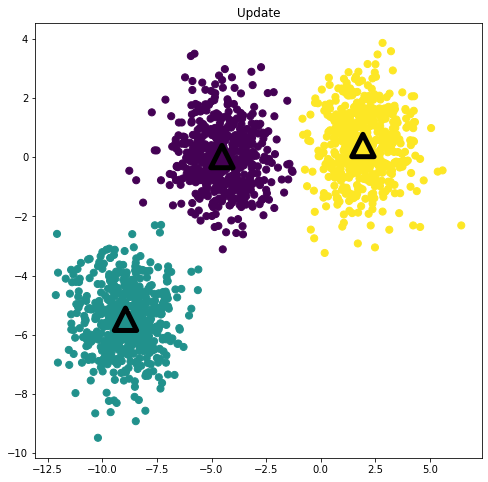

In [7]:
k = 3 # Number of clusters
steps = 10 # Number of steps to run k-means
plt.figure(figsize=(8, 8))

# initialize
centroids = init_centroids(k,X)
mapping = np.zeros((len(X))) # the initialization of the mapping is only for colors of the plot

plot_kmeans(title="Init")

for i in range(steps):
    
    clusters, mapping = assignToClusters(k, X, centroids)
    
    plot_kmeans(title="Assign")
    centroids = calcNewCentroids(clusters)
    plot_kmeans(title="Update")
plt.close()
    


# Clustering Trajectories
An important application clustering algorithms in the mobility domain is the clustering of movement trajectories. A movement trajectory is a set of recorded locations (points) that a person _visited_ or passed by and that can be used to describe the movement of a person. A very common type of movement trajectories are GPS-trajectories. Here the movement of a person is continuously recorded by a GPS device usually with a fixed temporal sampling temporal sampling rate of several seconds. 

When the movement of a person is recorded using a GPS device we call the raw gps trackpoints __positionfixes__, places where a person was stationary for a longer time are called __stay points__ and all positionfixes that are recorded between two stay points are aggregated as a __trip leg__ (a GPS movement trajectory)

In the following we look at examplary data of a publicly available GPS tracking set: [The geolife dataset](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F)


#### Load modules and some helpful constants/functions

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import os
nice_extent = (116.2, 40, 116.3, 40.1)
xmin, ymin, xmax, ymax = nice_extent

In [9]:
def write_shapefile(gdf, name):
    if not os.path.isdir('./shapefiles'):
        os.mkdir('./shapefiles')
    

    gdf.to_file(driver='ESRI Shapefile', filename= os.path.join('shapefiles', name))
    

In [10]:
crs_wgs = {'init' :'epsg:4326'}
crs_2D = {'init': 'epsg:32650'}
spts_all = gpd.read_file("geolife\\shp\\geolife_staypoints.shp")
tpls_all = gpd.read_file("geolife\\shp\\geolife_triplegs.shp")

### subsample data for speed
Some calculations can be slow, use the subsampled version to try things out

In [11]:
tmin = 1242856800 #+10*24*60*60
tmax = 1242943199 #+10*24*60*60

tpls = tpls_all[(tpls_all['started_at'] > tmin) & (tpls_all['started_at'] < tmax)].copy()
spts = spts_all[(spts_all['started_at'] > tmin) & (spts_all['started_at'] < tmax)].copy()

print("There are {:.0f} triplegs and {:.0f} staypoints".format(tpls.shape[0], spts.shape[0]))


There are 12 triplegs and 12 staypoints


# Clustering trajectories using descriptive features
In their usual form, most clustering algorithms are not compatible with trajectories as an input. One way to cluster trajectoires is to use descriptive (scalar) features as an input instead of the trajectory itself.

To be able to use the k-means clustering algorithm we create three features that describe each movement trajectory. Duration, distance and speed.

## Calculate duration

In [12]:
tpls_all["duration"] = tpls_all["finished_a"] - tpls_all["started_at"]

## Calculate distance
To calculate a meaningful distance, be aware that you have to use a projected coordinate system.

In [13]:
tpls_all2D = tpls_all.to_crs(crs_2D)
tpls_all["length"] = tpls_all2D["geometry"].length
tpls_all["speed"] = tpls_all["length"]/tpls_all["duration"] *3.6


## Inspect the data visually
If you plot the data using the script below, you will notice that your data is distributed in a strange way with many outliers. Think of a good data transformation that helps to have the data distributed in a more evenly manner! 

Text(0, 0.5, 'duration in m')

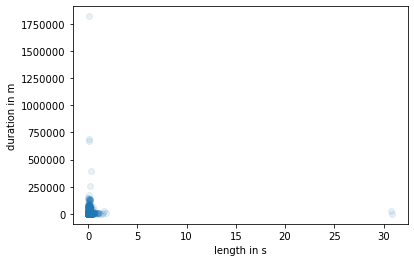

In [14]:
fig, ax = plt.subplots()

ax.scatter(tpls_all.length, tpls_all.duration, marker="o", alpha=0.1)
ax.set_xlabel('length in s')
ax.set_ylabel('duration in m')

## Plot transformation
Plot your data after your transformation

Text(0, 0.5, 'log duration in m')

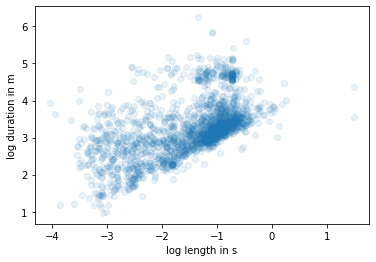

In [15]:
fig, ax = plt.subplots()

ax.scatter(np.log10(tpls_all.length), np.log10(tpls_all.duration), marker="o", alpha=0.1)
ax.set_xlabel('log length in s')
ax.set_ylabel('log duration in m')

## clustering
Try clustering the data using the KMeans algorithm. Create two different clustering using two sets of features:
- Clustering 1: Use distance and duration as features
- Clustering 2: Use only speed as features

What could be a meaningful number of clusters if you think of mobility?

In [16]:
from sklearn.cluster import KMeans

In [17]:
km = KMeans(n_clusters=8)
km.fit(np.log10(tpls_all[['length', 'duration']]))
tpls_all['clst_durdist'] = km.labels_

km.fit(np.log10(tpls_all["speed"].values.reshape(-1, 1)))
tpls_all['clst_speed'] = km.labels_

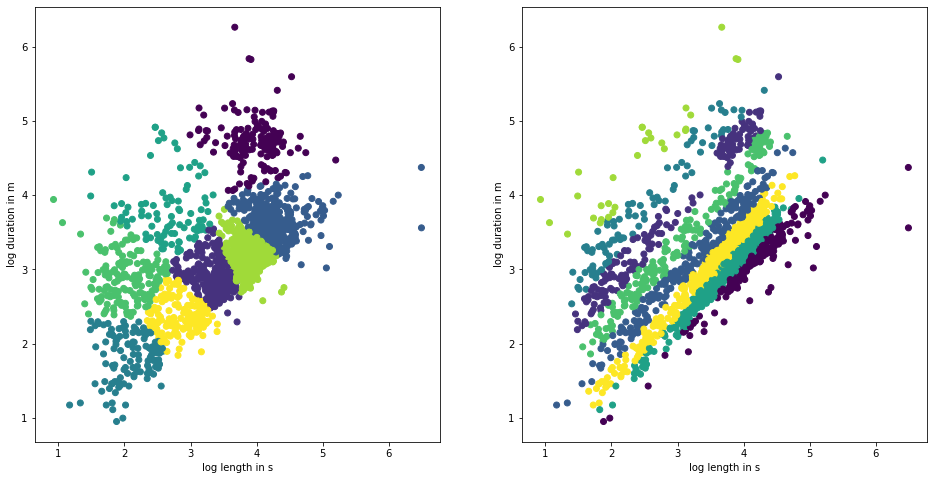

In [18]:



fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].scatter(x=np.log10(tpls_all['length']), y=np.log10(tpls_all['duration']), c=tpls_all['clst_durdist'])
ax[1].scatter(x=np.log10(tpls_all['length']), y=np.log10(tpls_all['duration']), c=tpls_all['clst_speed'])
for a in ax:
    a.set_xlabel('log length in s')
    a.set_ylabel('log duration in m')

### Understanding the results
In unsupervised learning it is often hard to estimate if what you did makes any sense. Therefore it is important to carefully look at the results carefully. 
- Print the cluster center of your clusterings and think about their meaning for your cluster. Does the clustering make sense?
- Use the `write_shapefile` function that is defined about to save your geodataframe as a shapefile and examine the clustering result with your favorite GIS software

In [19]:
buff = list(km.cluster_centers_**10)
buff.sort()
print(buff)
write_shapefile(tpls_all, 'trajectories')

[array([1.37090252e-07]), array([2.03820666e-06]), array([0.01535384]), array([0.09008643]), array([1.32707471]), array([18.69370104]), array([80.21215988]), array([125.22046818])]


# Cluster trajectories
Another way to cluster trajectories that takes into account the geometry of the trajectory is based on similarity metrics such as the frechet distance. The common approach is to use the distance metric to calculate the pairwise distance of all trajectories and store it in a so-called distance matrix. Most of the common clustering implementations can cluster the trajectories directly based on this matrix.

In [20]:
from utils import calculate_distance_matrix, plot_nb_dists, norm_coords
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import shapely

## calcualte the distance matrix using the frechet distance. 
- Use the prepared function `utils\calculate_distance_matrix` to calculate the distance matrix.
- Visualize the distance matrix
- Normalize your distance matrix
- Cluster the trajectories based on the distance matrix
- save the clustering into a shapefile and have a look with your favorite GIS software

**Important:** Calculating the pairwise distance is very expensive in terms of computation. Best is to only do it with 10 Trajectories at a time. 
**Important II:** Use the data in a projected coordinate system. 




In [21]:
tpls2D = tpls_all2D.iloc[10:20]
gdf = tpls2D.copy()
D_frechet = StandardScaler().fit_transform(calculate_distance_matrix(gdf, distance='frechet'))


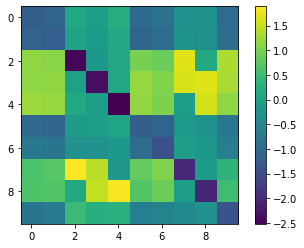

In [22]:
#D_frechet = np.log(D_frechet+1)
plt.figure()
plt.imshow(D_frechet)
plt.colorbar()


In [23]:
# This function plots clusters of trajectories 

def plot_colored_lines(gdf, labels, ax=None):
    c = labels
    colors = plt.cm.jet(np.linspace(0,1,max(c)+1))
    gdf.plot(color=colors[c], ax=ax)

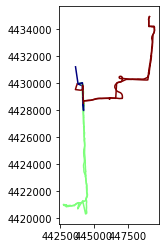

In [24]:
# kmeans D_frechet
km = KMeans(3)
km.fit(D_frechet)
gdf['D_fre'] =  km.labels_
plot_colored_lines(gdf, km.labels_)


write_shapefile(gdf, 'clustered_trajectories')

### Bonus: Use dtw

In [25]:
#D_dtw = calculate_distance_matrix(gdf, distance='dtw')

#D_dtw_norm = calculate_distance_matrix(gdf_norm, distance='dtw')
#D_dtw = StandardScaler().fit_transform(D_dtw)